**Importing Required Libraries**

In [102]:
import numpy as np
import pandas as pd

import unicodedata, re, string
import nltk

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score
import os


import re
from tqdm import tqdm
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='bs4')

In [103]:
train = pd.read_csv("../input/sentimental-analysis/train.tsv", sep="\t")
test = pd.read_csv("../input/sentimental-analysis/test.tsv", sep="\t")

**Exploring the data content**

The sentiment labels;

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

In [104]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [29]:
train.loc[train['SentenceId'] == 1]

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
58,59,1,much,2
59,60,1,of a story,2
60,61,1,a story,2
61,62,1,story,2


In [30]:
train.loc[train['SentenceId'] == 2]

,PhraseId,SentenceId,Phrase,Sentiment
63,64,2,"This quiet , introspective and entertaining in...",4
64,65,2,"This quiet , introspective and entertaining in...",3
65,66,2,This,2
66,67,2,"quiet , introspective and entertaining indepen...",4
67,68,2,"quiet , introspective and entertaining",3
68,69,2,quiet,2
69,70,2,", introspective and entertaining",3
70,71,2,introspective and entertaining,3
71,72,2,introspective and,3
72,73,2,introspective,2


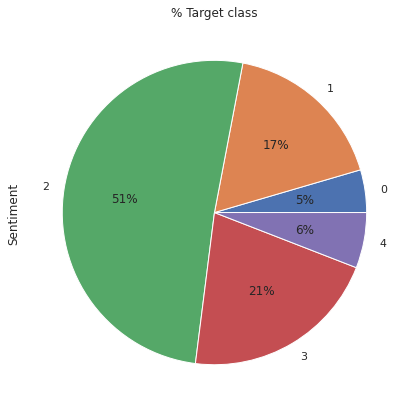

In [31]:
((train.groupby('Sentiment')['Sentiment'].count()/train.shape[0])*100).plot(kind='pie',figsize=(7,7),title='% Target class', autopct='%1.0f%%')

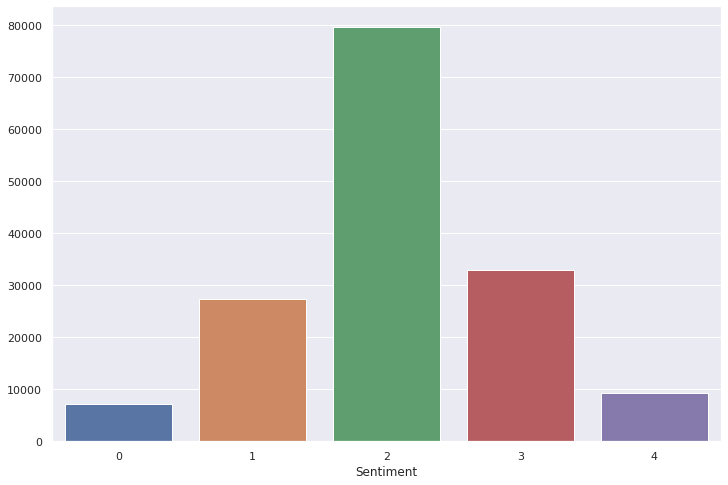

In [32]:
dist = train.groupby(["Sentiment"]).size()

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(dist.keys(), dist.values);

In [33]:
train['PhraseLength']=train['Phrase'].apply(lambda x: len(x))
train.sort_values(by='PhraseLength', ascending=False).head()

,PhraseId,SentenceId,Phrase,Sentiment,PhraseLength
105155,105156,5555,... spiced with humor -LRB- ' I speak fluent f...,3,283
43802,43803,2124,-LRB- City -RRB- reminds us how realistically ...,3,279
145399,145400,7901,-LRB- Clooney 's -RRB- debut can be accused of...,3,268
145400,145401,7901,-LRB- Clooney 's -RRB- debut can be accused of...,3,266
85187,85188,4406,The film was produced by Jerry Bruckheimer and...,1,266


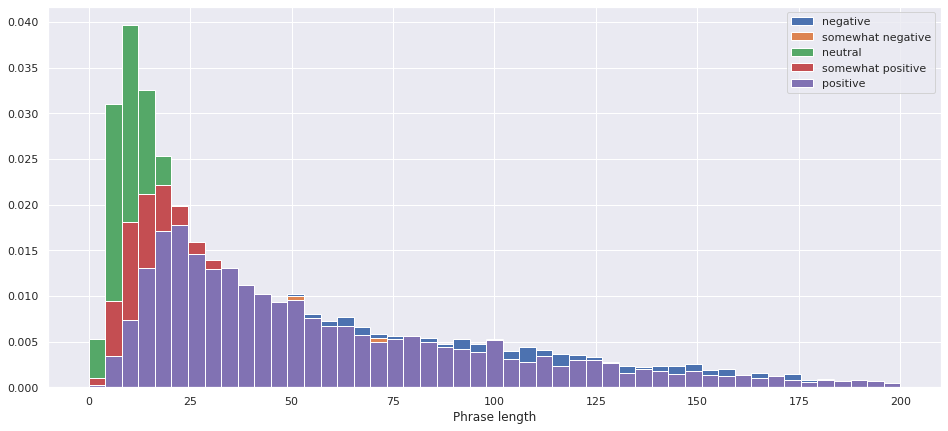

In [34]:
plt.figure(figsize=(16,7))
bins=np.linspace(0,200,50)
plt.hist(train[train['Sentiment']==0]['PhraseLength'],bins=bins,density=True,label='negative')
plt.hist(train[train['Sentiment']==1]['PhraseLength'],bins=bins,density=True,label='somewhat negative')
plt.hist(train[train['Sentiment']==2]['PhraseLength'],bins=bins,density=True,label='neutral')
plt.hist(train[train['Sentiment']==3]['PhraseLength'],bins=bins,density=True,label='somewhat positive')
plt.hist(train[train['Sentiment']==4]['PhraseLength'],bins=bins,density=True,label='positive')
plt.xlabel('Phrase length')
plt.legend()
plt.show()


In [35]:
train.drop(['PhraseLength'], axis=1)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


Finding word frequency 

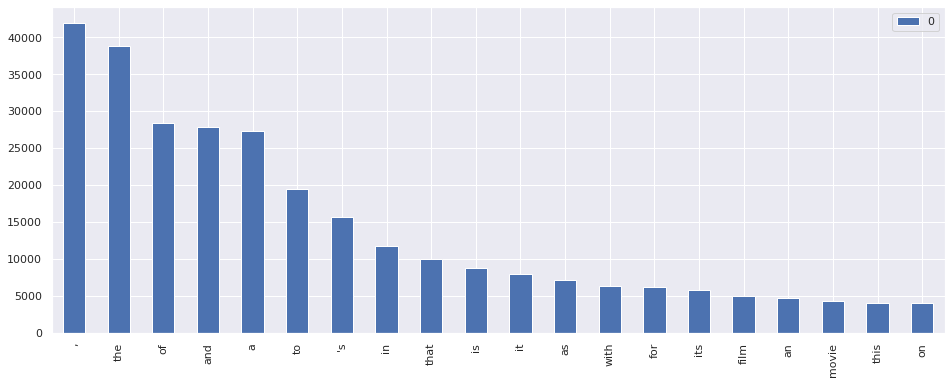

In [36]:
text_list=[]  
for index, row in train.iterrows(): 
    text_list.append((row['Phrase'])) 
text_list

total_words=''.join(text_list)
total_words=word_tokenize(total_words)

freq_words=FreqDist(total_words)
word_frequency=FreqDist(freq_words)
pd.DataFrame(word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(16,6),grid=True)

**Pre-processing**

In [37]:
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    new_words = []
    for word in words:
         new_words = set(stopwords.words('english'))
    return new_words

def stem_words(words):
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def preprocess(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    words = remove_stopwords(words)
    return words

In [38]:
def data_preprocessing(df):
    reviews = []
    for raw in tqdm(df['Phrase']):
        # remove html tag
        text = BeautifulSoup(raw, 'lxml').get_text()
        # remove non-letters
        letters_only = re.sub('[^a-zA-Z]', ' ', text)
        # split(lowercase)
        words = word_tokenize(letters_only.lower())
        # get stoplist words
        stops = set(stopwords.words('english'))
        # remove stopwords / get non-stopwords list
        non_stopwords = [word for word in words if not word in stops]
        # lemmatize word to its lemma
        lemma_words = [lemmatizer.lemmatize(word) for word in non_stopwords]    
        reviews.append(lemma_words)
    return reviews

In [109]:
#%time train_sentences = preprocess(train)
#%time test_sentences = preprocess(test)
%time train_sentences = data_preprocessing(train)
%time test_sentences = data_preprocessing(test)
len(train_sentences), len(test_sentences)

  0%|          | 100/66292 [00:00<01:06, 993.06it/s]

CPU times: user 1min 49s, sys: 4.98 s, total: 1min 54s
Wall time: 1min 55s


100%|██████████| 66292/66292 [00:48<00:00, 1375.34it/s]

CPU times: user 46 s, sys: 2.12 s, total: 48.2 s
Wall time: 48.2 s


(156060, 66292)

**Splitting of data and training model**

In [40]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

In [41]:
# extract label columns and to_categorical
target = train.Sentiment.values
y_target = to_categorical(target)
num_classes = y_target.shape[1]

In [92]:
print(target)

[1 2 2 ... 3 2 2]


In [42]:
# train set => split to train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_sentences, y_target, test_size=0.2, stratify=y_target)

In [43]:
# keras tokenzier initialization
unique_words = set()
len_max = 0
for sent in tqdm(X_train):
    unique_words.update(sent)
    if len_max < len(sent):
        len_max = len(sent)
len(list(unique_words)), len_max

100%|██████████| 124848/124848 [00:00<00:00, 557121.79it/s]


(13619, 30)

In [44]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

X_train.shape, X_val.shape, X_test.shape

((124848, 30), (31212, 30), (66292, 30))

In [45]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [46]:
early_stopping = EarlyStopping(min_delta=0.001, mode='max', monitor='val_acc', patience=2)
callback = [early_stopping]

In [47]:
# build model
model = Sequential()
model.add(Embedding(len(list(unique_words)), 300, input_length=len_max))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=False))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           4085700   
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 128)           219648    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 4,361,761
Trainable params: 4,361,761
Non-trainable params: 0
____________________________________________

In [48]:
%%time

# fit
with tf.device("/gpu:0"):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=256, verbose=1, callbacks=callback)

Epoch 1/10
488/488 [==============================] - 150s 308ms/step - loss: 0.9965 - accuracy: 0.5995 - val_loss: 0.8692 - val_accuracy: 0.6452
Epoch 2/10
488/488 [==============================] - 151s 309ms/step - loss: 0.8185 - accuracy: 0.6645 - val_loss: 0.8415 - val_accuracy: 0.6517
Epoch 3/10
488/488 [==============================] - 153s 314ms/step - loss: 0.7491 - accuracy: 0.6889 - val_loss: 0.8332 - val_accuracy: 0.6606
Epoch 4/10
488/488 [==============================] - 151s 309ms/step - loss: 0.7080 - accuracy: 0.7039 - val_loss: 0.8513 - val_accuracy: 0.6664
Epoch 5/10
488/488 [==============================] - 149s 306ms/step - loss: 0.6796 - accuracy: 0.7132 - val_loss: 0.8634 - val_accuracy: 0.6639
Epoch 6/10
488/488 [==============================] - 150s 308ms/step - loss: 0.6626 - accuracy: 0.7188 - val_loss: 0.9006 - val_accuracy: 0.6643
Epoch 7/10
488/488 [==============================] - 149s 305ms/step - loss: 0.6487 - accuracy: 0.7253 - val_loss: 0.9092 -

In [58]:
y_pred = model.predict_classes(X_test)
attribute_names = ["Sentiment"]

results = pd.DataFrame(columns = attribute_names)
results.Sentiment = y_pred
results['Sentiment'] = results['Sentiment'].map({0:'negative',1:'somewhat negative',2:'neutral',3:'somewhat positive',4:'positive'})
print(results)

               Sentiment
0      somewhat positive
1      somewhat positive
2                neutral
3      somewhat positive
4      somewhat positive
...                  ...
66287  somewhat negative
66288  somewhat negative
66289            neutral
66290            neutral
66291  somewhat negative

[66292 rows x 1 columns]
